In [18]:
# Imports for numerical calculations
import math
import numpy as np
import gmpy2
from fpylll import IntegerMatrix, LLL
import gc

# Utility
import sys
import time
import matplotlib.pyplot as plt

In [3]:
### Define helper functions

def coefficients_gen_norm(
        p: int,
        stdev: float,
        rng: np.random.Generator
    ) -> np.typing.NDArray[np.int_]:
    """
    Generate random cyclotomic integer summed from `p`th roots of unity
    with each coefficient rounded to an integer from a sample of the Gaussian distribution.

    ### Parameters
    - `p`: order of root of unity.
    - `stdev`: standard deviation of Gaussian distribution.
    - `rng`: NumPy random number generator.

    ### Returns:
    - `coefs`: coefficients of roots of unity in sum, where `coefs[i]` corresponds to the `i`th root.
    """

    return np.rint(rng.normal(loc=0.0, scale=stdev, size=p))


def coefficients_gen_l1_pos(
        p: int,
        l1: int,
        rng: np.random.Generator
    ) -> np.typing.NDArray[np.int_]:
    """
    Generate random cyclotomic integer summed from `p`th roots of unity
    sampled uniformly at random from the positive part of the `l1` sphere.
    
    ### Parameters
    - `p`: order of root of unity.
    - `l1`: sum of coefficients in desired cyclotomic integer.
    - `rng`: NumPy random number generator.
    
    ### Returns:
    - `coefs`: coefficients of roots of unity in sum, where `coefs[i]` corresponds to the `i`th root.
    """

    # Divide coefficients with stars-and-bars approach
    dividers = rng.choice(l1 + 1, size = p - 1, replace=True)
    dividers.sort()

    return np.diff(dividers, prepend=0, append=l1)


def coefficients_gen_l1(
        p: int, 
        l1: int,
        rng: np.random.Generator
    ) -> np.typing.NDArray[np.int_]:
    """
    Generate random cyclotomic integer summed from `p`th roots of unity
    sampled uniformly at random from `l1` sphere.
    
    ### Parameters
    - `p`: order of root of unity.
    - `l1`: sum of absolute value of coefficients in desired cyclotomic integer.
    - `rng`: NumPy random number generator.
    
    ### Returns:
    - `coefs`: coefficients of roots of unity in sum, where `coefs[i]` corresponds to the `i`th root.
    """

    # TODO: do we want to work with integers bigger than 2 ** 64?

    # Uniformly select which coefficients are negative
    negatives = rng.integers(0, 1, size=p, endpoint=True)

    return np.multiply(
        coefficients_gen_l1_pos(p, l1, rng),
        -2 * negatives + 1
    )


def recover_sparse_cyclotomic(
        coefs: np.typing.NDArray[np.int_], 
        p: int, 
        Ascale: int, 
        Bscale: int, 
        last_root: bool, 
        noise: gmpy2.mpfr, 
        rng: np.random.Generator,
        prec=53
    ) -> IntegerMatrix:
    """
    For a cyclotomic integer `z` summed from `p`th roots of unity,
    generates LLL (short, nearly orthogonal) basis vectors to approximate `z` with integer relations. \n

    Each basis vector `vec` consists of:
    - `vec[0:2]` corresponding to the Re and Im parts of the objective value.
    - `vec[2:p+1+last_root]` corresponding to the coefficients for each root of unity.
    - `vec[-1]` corresponding to the target value.

    ### Parameters:
    - `coefs`: coefficients in cyclotomic integer decomposition of `z`.
    - `p`: order of root of unity.
    - `Ascale`: lattice scaling factor for objective complex values.
    - `Bscale`: lattice scaling factor for number of vectors summed.
    - `last_root`: whether to include `p-1`th root of unity in linear combinations.
    - `noise`: standard deviation of Gaussian noise to add to input cyclotomic integer.
    - `rng`: NumPy random number generator.
    - `prec`: number of precision bits to define float mantissa. Default `53` uses IEEE-754 `numpy.float64` for speed.

    ### Returns:
    - `exps`: list of number of roots of unity used in summing z, where `exps[i]` corresponds to the `i`th root.
    - `lll_mat`: list of candidate basis vectors as output of LLL algorithm.
    """

    # TODO: find whether there is a better initial ordering of basis vectors

    # Default precision: use numpy.float64 for speed
    if prec == 53:
        # Generate cyclotomic integer
        angles = 2 * np.pi * np.arange(p) / p
        roots_re = np.cos(angles)
        roots_im = np.sin(angles)
        z_re = np.dot(coefs, roots_re)
        z_im = np.dot(coefs, roots_im)

        # Add complex random Gaussian noise with stdev noise
        if noise:
            z_re += rng.normal(scale=noise/math.sqrt(2))
            z_im += rng.normal(scale=noise/math.sqrt(2))
    
    # Arbitrary precision: use gmpy2 wrapper of GMP and MPFR
    else:
        if prec < 1:
            raise ValueError("Precision must be a positive integer.")

        # Set up arbitrary precision environment
        ctx = gmpy2.get_context()
        ctx.precision = prec

        roots_re = [gmpy2.cos((2 * gmpy2.const_pi() * i) / p) for i in range(p)]
        roots_im = [gmpy2.sin((2 * gmpy2.const_pi() * i) / p) for i in range(p)]
        z_re = sum(root_re * coef for root_re, coef in zip(roots_re, coefs))
        z_im = sum(root_im * coef for root_im, coef in zip(roots_im, coefs))

        if noise:
            rs = gmpy2.random_state(int(rng.integers(sys.maxsize)))
            z_re += gmpy2.mpfr_nrandom(rs) * noise/gmpy2.rootn(2, 2)
            z_im += gmpy2.mpfr_nrandom(rs) * noise/gmpy2.rootn(2, 2)

    # Construct the lattice basis matrix
    M = IntegerMatrix(p + last_root, p + 2 + last_root)

    for i in range(p - 1 + last_root):
        M[i, 0] = int(round(roots_re[i] * Ascale)) # roots of unity real parts
        M[i, 1] = int(round(roots_im[i] * Ascale)) # roots of unity imaginary parts
        M[i, 2 + i] = Bscale # identity matrix
    
    # Set target row to real + imaginary parts
    M[-1, 0] = -1 * int(round(z_re * Ascale))
    M[-1, 1] = -1 * int(round(z_im * Ascale))
    M[-1, -1] = 1

    LLL.reduction(M)
    return M


def run_trials(
        orders: list[int], 
        gen: str,
        gen_param: int, 
        Ascale: int, 
        Bscale: int, 
        last_root: bool, 
        num_trials: int, 
        noise=gmpy2.mpfr(0), 
        seed=None,
        prec=53
    ) -> list[int]:
    """
    Tests success rate of using LLL algorithm to solve
    the cyclotomic integer decomposition integer relation problem.

    ### Parameters:
    - `orders`: list of orders of root of unity to test.
    - `gen`: sets generator for random cyclotomic integers:
    \t - "l1pos" samples cyclotomic integers from positive part of `l1` sphere of radius `gen_param` uniformly at random.
    \t - "l1" samples cyclotomic integers from `l1` sphere of radius `gen_param` uniformly at random.
    \t - "normal" samples coefficients from an unbiased normal distribution with standard deviation `gen_param`.
    - `gen_param`: see above.
    - `Ascale`: lattice scaling factor for objective complex values.
    - `Bscale`: lattice scaling factor for integer mapping. If set to 0:
    \t - in the noiseless case (`noise == 0.0`), `Bscale` defaults to `1`.
    \t - in the noisy case, computes optimal `Bscale` for each prime in `primes` for best success rate.
    - `last_root`: whether to include `p-1`th root of unity in linear combinations.
    - `num_trials`: number of trials to run for each `p` in `orders`.
    - `noise`: (optional) standard deviation of Gaussian noise to add to input cyclotomic integer. Default `0.0`.
    - `seed`: (optional) random seed for initializing random number generator.
    - `prec`: (optional) number of precision bits to define float mantissa. Default `53` uses IEEE-754 `numpy.float64`.

    ### Returns:
    - `results`: list of number of successes corresponding to `orders`.
    """

    # Generate placeholder to record correct trials for each prime
    results = [0] * len(orders)

    # Initialize and set random cyclotomic integer generator
    rng = np.random.default_rng(seed)

    if gen == "l1pos":
        generator = coefficients_gen_l1_pos
    elif gen == "l1":
        generator = coefficients_gen_l1
    elif gen == "normal":
        generator = coefficients_gen_norm
    else:
        raise ValueError("Select cyclotomic integer generation mode `l1pos`, `l1`, or `normal`.")
    
    # Run trials for each order in orders
    for i in range(len(orders)):
        p = orders[i]

        # TODO: re-test autocomputes Nscale if given noise
        if Ascale == 0 and noise != 0:
            Bval = (Ascale * p * noise) // (4.5 * (gen_param ** (2/3)))
        else:
            Bval = max(Bscale, 1)

        for _ in range(num_trials):
            coefs = generator(p, gen_param, rng)
            lll_mat = recover_sparse_cyclotomic(coefs, p, Ascale=Ascale, Bscale=Bval, last_root=last_root, noise=noise, rng=rng, prec=prec)

            # Match successful candidate vectors
            for row in lll_mat:
                if abs(row[-1]) == 1:
                    # Construct desired histogram of roots of unity
                    expected_arr = Bval * coefs

                    # Check if candidate vector and desired histogram differ by all 1's vector
                    candidate = np.array(row)
                    if not last_root:
                        candidate[-1] = 0
                    diff_vec = row[-1] * candidate[2:p+2] - expected_arr
                    results[i] += int((np.abs(diff_vec - diff_vec[0]) < 10 ** -3).all())
                    break
    return results


def run_trials_timed(
        orders: list[int], 
        gen: str,
        gen_param: int, 
        Ascale: int, 
        Bscale: int, 
        last_root: bool, 
        num_trials: int, 
        noise: gmpy2.mpfr, 
        seed=None,
        prec=53
    ) -> tuple[list[int], list[float]]:
    """
    Tests success rate and times of using LLL algorithm to solve
    the cyclotomic integer decomposition integer relation problem.
    See `run_trials` for input parameter details.

    ### Returns:
    - `results`: list of number of successes corresponding to `orders`.
    - `times`: list of times (in seconds) needed to run all trials for each prime in `orders`.
    """

    # Generate placeholder to record correct trials and time taken for each prime
    results = [0] * len(orders)
    times = [0.0] * len(orders)

    # Initialize and set random cyclotomic integer generator
    rng = np.random.default_rng(seed)

    if gen == "l1pos":
        generator = coefficients_gen_l1_pos
    elif gen == "l1":
        generator = coefficients_gen_l1
    elif gen == "normal":
        generator = coefficients_gen_norm
    else:
        raise ValueError("Select cyclotomic integer generation mode `l1pos`, `l1`, or `normal`.")
    
    # Run trials for each order in orders
    for i in range(len(orders)):
        start_time = time.time()
        p = orders[i]

        # autocomputes Nscale if given noise
        if Bscale == 0 and noise != 0:
            Bval = (Ascale * p * noise) // (4.5 * (gen_param ** (2/3)))
        else:
            Bval = max(Bscale, 1)

        for _ in range(num_trials):
            coefs = generator(p, gen_param, rng)
            lll_mat = recover_sparse_cyclotomic(coefs, p, Ascale=Ascale, Bscale=Bval, last_root=last_root, noise=noise, rng=rng, prec=prec)

            # Match successful candidate vectors
            for row in lll_mat:
                if abs(row[-1]) == 1:
                    # Construct desired histogram of roots of unity
                    expected_arr = Bval * coefs

                    # Check if candidate vector and desired histogram differ by all 1's vector
                    candidate = np.array(row)
                    if not last_root:
                        candidate[-1] = 0
                    diff_vec = row[-1] * candidate[2:p+2] - expected_arr
                    results[i] += int((np.abs(diff_vec - diff_vec[0]) < 10 ** -3).all())
                    break
        
        # Record times for prime
        times[i] = time.time() - start_time
    return results, times


In [13]:
### Check LLL matrix output and selected candidates for a single trial
rng = np.random.default_rng()
p = 5
l1 = 2 ** 21
Alog = 40
last_root = False
Bval = 3
# Bval = int((10 ** Mlog * p * 0.001) // (4.5 * (l1 ** (2/3))))
# print(Bval)
coefs = coefficients_gen_l1(p, l1, rng)
print(coefs)
lll_mat = recover_sparse_cyclotomic(coefs, p, Ascale=10**Alog, Bscale=Bval, last_root=last_root, noise=0, rng=rng, prec=128)
expected_arr = Bval * coefs
print(lll_mat)

for row in lll_mat:
    if abs(row[-1]) == 1:
        candidate = np.array(row)
        print(candidate)
        if not last_root:
            candidate[-1] = 0
        print(np.divide(row[-1] * candidate[2:p+2], Bval))
        diff_vec = row[-1] * candidate[2:p+2] - expected_arr
        print(diff_vec - diff_vec[0])
        break

[-163895  365924 -283471  982490  301372]
[             -17246784                2863968              -1395801                193656              -1754529               2043354               1 ]
[ -15250282207006752960  -13584222692481381504  22351709675747686602  28421345763288227718  28862522846707729890 -72321700565477638737 -42235383784016 ]
[   4104033734674136448  -12685446598065912544 -57652209325600733397  67905312050688308220 -56482758271791381453 -41896716601225242045 -27345656421918 ]
[   5812712995130199040   75019455082462287200 -42212049844519480104 -79122974383641173436  11973603488098289421 -67140427628303883897  14036175952217 ]
[ -22954877369190556352 -105941736024082336320  -4237894914135644514 -90155312425135868547  30507116251300515276 -13416466506689432316  29258021852328 ]
[-17246784   2863968  -1395801    193656  -1754529   2043354         1]
[-465267.   64552. -584843.  681118.       0.]
[0 0 0 0 0]


In [ ]:
### Run trials

# As of last commit: this space iterates through potential error and superposition values. 
# A prime stops being tested when its accuracy values fall too low.

# orders = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

trials = 1000
orders = np.array([5, 7, 11, 13, 17, 19, 23])
# Alogs = [40]
# Alogs = [15, 18, 37]
# precs = [53, 64, 128]
l1logs = np.arange(3.0, 62.0, 0.25)
# l1logs= [22]
# orders = np.arange(5, 100)
# orders = [5]
# M = 10 ** 15
# results = [0] * len(l1logs)
# times = [0.0] * len(l1logs)

for l1log in l1logs:
    results = run_trials(orders=list(orders), gen="l1", gen_param = int(2 ** l1log), Ascale=int(10 ** 39), Bscale=5, last_root=False, num_trials=trials, noise=0, prec=128)
    print(f"log stdev = {l1log}: {results}")
    orders = orders[np.array(results) >= 400]
    gc.collect()
    if len(orders) == 0:
        break

# for i in np.arange(1, 3):
#     results = run_trials(orders=orders, l1=3, Mscale=(10 ** Mlogs[i]), Nscale=20, last_root=False, num_trials=trials, noise=0, prec=precs[i])
#     print(f"precision = {precs[i]}, log M = {Mlogs[i]}: {results}")

# for i in range(len(Mlogs)):
    # result = run_trials(orders=orders, l1=2 ** 62, Mscale=(10 ** Mlogs[i]), Nscale=5, last_root=True, num_trials=trials, noise=0, prec=256)
    # print(f"log M = {Mlogs[i]}: {result}")
    # results[i] = result[0]
    # times[i] = t[0]

# print(np.round(times, 3).tolist())

# results = run_trials(orders=[13], gen="l1", gen_param=2 ** 61, Ascale=10 ** 60, Bscale=3, last_root=False, num_trials=10000, noise=0, prec=256)
# print(results)


log stdev = 3.0: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 3.25: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 3.5: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 3.75: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 4.0: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 4.25: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 4.5: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 4.75: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 5.0: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 5.25: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 5.5: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 5.75: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 6.0: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 6.25: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 6.5: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 6.75: [1000, 1000, 1000, 1000, 1000, 1000, 1000]
log stdev = 7.0: [1000, 1000, 10

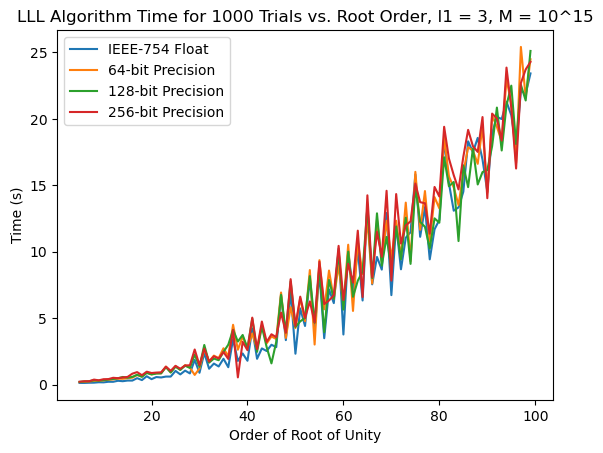

In [ ]:
### Plot algorithm times vs. root of unity order or l1 norm or A (allowing negative coefficients)

# vs. root of unity order, l1 = 3, A = 10 ** 15
orders = np.arange(5, 100)
yo_new = [0.123, 0.122, 0.136, 0.141, 0.173, 0.165, 0.209, 0.207, 0.284, 0.252, 0.3, 0.299, 0.479, 0.336, 0.625, 0.406, 0.565, 0.533, 0.6, 0.6, 1.027, 0.763, 1.048, 0.838, 1.854, 0.885, 2.374, 1.189, 1.579, 1.361, 1.941, 1.305, 3.42, 1.777, 2.339, 1.79, 4.213, 1.938, 2.72, 2.524, 2.995, 2.816, 6.732, 3.343, 6.999, 2.32, 5.734, 4.406, 7.976, 4.148, 8.397, 3.487, 7.162, 6.129, 10.224, 3.767, 10.039, 6.976, 10.145, 6.327, 13.564, 7.544, 9.603, 8.651, 12.912, 6.73, 12.046, 8.676, 11.05, 11.469, 15.818, 11.121, 13.352, 9.425, 11.686, 12.391, 18.457, 15.152, 13.087, 13.335, 14.517, 18.309, 17.482, 18.567, 16.938, 14.535, 18.921, 20.15, 19.987, 21.288, 20.277, 17.789, 22.128, 21.878, 23.42]
yo_64 = [0.184, 0.205, 0.234, 0.272, 0.288, 0.315, 0.36, 0.386, 0.444, 0.434, 0.476, 0.519, 0.715, 0.596, 0.9, 0.764, 0.859, 0.842, 1.348, 0.919, 1.374, 1.125, 1.461, 1.272, 0.725, 1.207, 2.672, 1.744, 2.177, 1.985, 2.732, 2.127, 4.5, 2.621, 3.606, 2.743, 3.845, 2.671, 4.46, 3.094, 3.617, 3.429, 6.928, 3.509, 5.825, 4.249, 6.501, 4.769, 8.618, 3.011, 9.363, 5.664, 8.581, 6.453, 8.967, 6.01, 10.527, 5.541, 10.778, 8.317, 12.454, 7.606, 12.41, 9.274, 12.334, 9.489, 12.331, 9.556, 13.696, 9.287, 16.011, 11.65, 14.566, 10.778, 14.108, 13.263, 18.612, 15.673, 14.836, 13.511, 15.939, 17.86, 17.62, 16.613, 19.421, 14.433, 20.247, 19.399, 18.295, 22.999, 21.151, 16.677, 25.416, 21.613, 24.485]
yo_128 = [0.193, 0.234, 0.246, 0.323, 0.287, 0.329, 0.374, 0.423, 0.474, 0.57, 0.519, 0.575, 0.741, 0.586, 0.874, 0.76, 0.826, 0.842, 1.308, 0.907, 1.347, 1.097, 1.419, 1.252, 2.256, 1.333, 2.98, 1.647, 1.955, 1.831, 2.455, 3.0, 4.117, 3.239, 3.732, 2.741, 4.963, 2.465, 4.362, 2.817, 1.594, 3.209, 6.756, 3.936, 7.775, 4.333, 4.757, 5.017, 8.162, 4.655, 8.843, 3.939, 7.874, 6.445, 10.04, 5.642, 10.005, 6.605, 7.819, 8.508, 13.339, 8.021, 12.889, 8.95, 11.109, 8.741, 11.901, 9.424, 12.563, 9.083, 14.908, 12.248, 11.872, 10.234, 12.511, 12.182, 17.11, 14.929, 15.249, 10.801, 16.504, 14.859, 17.778, 15.061, 15.995, 16.144, 17.94, 20.849, 17.62, 21.022, 22.499, 18.105, 22.562, 21.384, 25.113]
yo_256 = [0.215, 0.248, 0.248, 0.372, 0.317, 0.402, 0.408, 0.508, 0.479, 0.534, 0.572, 0.818, 0.936, 0.703, 0.969, 0.867, 0.9, 0.92, 1.349, 1.032, 1.409, 1.186, 1.433, 1.453, 2.638, 1.457, 2.708, 1.734, 2.128, 1.963, 2.445, 1.927, 4.103, 0.539, 3.215, 2.584, 5.036, 2.668, 4.743, 3.206, 3.785, 3.565, 5.42, 3.898, 7.933, 4.397, 6.618, 5.009, 6.258, 4.67, 9.253, 6.061, 6.328, 6.725, 10.44, 6.361, 9.092, 7.668, 11.584, 6.587, 14.245, 8.08, 11.492, 9.619, 14.586, 7.824, 14.339, 10.614, 11.978, 12.285, 15.133, 13.729, 13.649, 11.357, 14.875, 14.156, 19.404, 17.011, 15.763, 14.688, 17.149, 19.172, 17.945, 17.512, 20.137, 14.026, 20.396, 20.025, 18.368, 23.86, 20.839, 16.262, 22.698, 23.721, 24.288]

# vs. l1 norm, p = [5, 7], A = 10 ** 15
l1_logs = np.arange(2, 51)
yr5_new = [0.197, 0.179, 0.175, 0.172, 0.181, 0.175, 0.18, 0.182, 0.195, 0.188, 0.192, 0.185, 0.192, 0.181, 0.189, 0.182, 0.188, 0.185, 0.198, 0.186, 0.191, 0.194, 0.19, 0.183, 0.191, 0.186, 0.191, 0.183, 0.185, 0.188, 0.184, 0.183, 0.184, 0.182, 0.191, 0.176, 0.183, 0.18, 0.186, 0.182, 0.185, 0.184, 0.185, 0.185, 0.185, 0.185, 0.183, 0.18, 0.185]
yr5_64 = [0.263, 0.252, 0.256, 0.27, 0.259, 0.268, 0.248, 0.284, 0.258, 0.252, 0.26, 0.269, 0.276, 0.271, 0.273, 0.264, 0.263, 0.265, 0.308, 0.267, 0.284, 0.259, 0.276, 0.273, 0.261, 0.267, 0.291, 0.263, 0.323, 0.266, 0.277, 0.263, 0.28, 0.264, 0.273, 0.282, 0.263, 0.267, 0.261, 0.251, 0.278, 0.277, 0.268, 0.26, 0.264, 0.259, 0.259, 0.272, 0.315]
yr5_128 = [0.272, 0.259, 0.275, 0.271, 0.279, 0.276, 0.273, 0.27, 0.277, 0.299, 0.271, 0.277, 0.274, 0.271, 0.275, 0.277, 0.279, 0.281, 0.282, 0.287, 0.276, 0.282, 0.283, 0.27, 0.286, 0.283, 0.27, 0.281, 0.284, 0.274, 0.294, 0.279, 0.305, 0.278, 0.274, 0.285, 0.305, 0.288, 0.312, 0.277, 0.282, 0.275, 0.274, 0.278, 0.276, 0.266, 0.269, 0.29, 0.271]
yr5_256 = [0.295, 0.294, 0.286, 0.278, 0.266, 0.283, 0.301, 0.302, 0.331, 0.341, 0.294, 0.31, 0.292, 0.32, 0.303, 0.312, 0.292, 0.314, 0.29, 0.304, 0.309, 0.297, 0.302, 0.303, 0.306, 0.294, 0.306, 0.294, 0.303, 0.317, 0.321, 0.301, 0.313, 0.299, 0.288, 0.296, 0.292, 0.303, 0.304, 0.301, 0.303, 0.315, 0.301, 0.306, 0.298, 0.306, 0.304, 0.308, 0.299]
yr7_new = [0.214, 0.21, 0.213, 0.206, 0.207, 0.206, 0.221, 0.226, 0.238, 0.225, 0.228, 0.229, 0.228, 0.245, 0.226, 0.226, 0.217, 0.223, 0.214, 0.218, 0.216, 0.222, 0.215, 0.223, 0.215, 0.222, 0.225, 0.233, 0.218, 0.22, 0.216, 0.226, 0.226, 0.216, 0.219, 0.222, 0.216, 0.221, 0.214, 0.224, 0.217, 0.22, 0.221, 0.225, 0.215, 0.221, 0.217, 0.247, 0.22]
yr7_64 = [0.312, 0.343, 0.335, 0.331, 0.328, 0.321, 0.331, 0.333, 0.341, 0.336, 0.33, 0.342, 0.363, 0.343, 0.323, 0.337, 0.339, 0.316, 0.345, 0.332, 0.334, 0.327, 0.349, 0.333, 0.338, 0.353, 0.331, 0.343, 0.336, 0.332, 0.33, 0.337, 0.322, 0.335, 0.347, 0.344, 0.346, 0.339, 0.327, 0.341, 0.339, 0.349, 0.336, 0.342, 0.333, 0.331, 0.331, 0.337, 0.341]
yr7_128 = [0.302, 0.338, 0.328, 0.323, 0.337, 0.341, 0.343, 0.346, 0.357, 0.36, 0.343, 0.358, 0.362, 0.353, 0.35, 0.342, 0.344, 0.351, 0.344, 0.348, 0.362, 0.368, 0.347, 0.348, 0.344, 0.342, 0.354, 0.349, 0.355, 0.355, 0.339, 0.339, 0.349, 0.351, 0.36, 0.349, 0.354, 0.347, 0.349, 0.331, 0.342, 0.341, 0.353, 0.344, 0.345, 0.354, 0.362, 0.352, 0.356]
yr7_256 = [0.357, 0.369, 0.34, 0.335, 0.351, 0.342, 0.381, 0.376, 0.375, 0.384, 0.394, 0.369, 0.362, 0.368, 0.401, 0.367, 0.373, 0.378, 0.373, 0.359, 0.367, 0.367, 0.375, 0.366, 0.36, 0.384, 0.36, 0.359, 0.385, 0.373, 0.367, 0.381, 0.369, 0.374, 0.373, 0.358, 0.38, 0.366, 0.366, 0.372, 0.365, 0.367, 0.384, 0.371, 0.366, 0.378, 0.379, 0.375, 0.36]

# vs. A, p = 5, l1 = 3
# TODO: I think times get very bad when all of p, l1, and A are somewhat high. need to test?
Alogs = np.arange(2, 51)
yA_256 = [0.36, 0.391, 0.374, 0.394, 0.391, 0.328, 0.315, 0.316, 0.338, 0.335, 0.327, 0.309, 0.298, 0.324, 0.312, 0.334, 0.326, 0.331, 0.349, 0.339, 0.321, 0.322, 0.332, 0.332, 0.337, 0.345, 0.34, 0.345, 0.42, 0.387, 0.372, 0.385, 0.388, 0.367, 0.356, 0.33, 0.358, 0.339, 0.358, 0.358, 0.358, 0.387, 0.343, 0.352, 0.332, 0.35, 0.341, 0.339, 0.345]

# Plotting
# plt.plot(Alogs, yA_256)
plt.plot(orders, yo_new, label="IEEE-754 Float")
plt.plot(orders, yo_64, label="64-bit Precision")
plt.plot(orders, yo_128, label="128-bit Precision")
plt.plot(orders, yo_256, label="256-bit Precision")
plt.title("LLL Algorithm Time for 1000 Trials vs. Root Order, l1 = 3, A = 10^15")
plt.xlabel("Order of Root of Unity")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

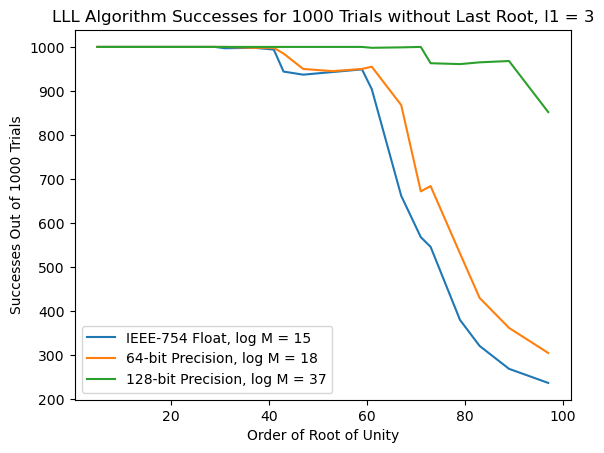

In [ ]:
### Plot successes (noiseless) over orders/primes (outdated-ish)

# Successes vs. orders, l1 = 3, A = 10 ** 15, allowing negative coefficients
orders = np.arange(5, 100)
results3n = [1000, 47, 1000, 75, 318, 70, 1000, 32, 1000, 121, 463, 95, 1000, 55, 1000, 90, 653, 154, 1000, 57, 967, 151, 701, 131, 1000, 77, 1000, 120, 769, 134, 976, 54, 1000, 153, 779, 94, 1000, 63, 1000, 155, 801, 170, 1000, 87, 1000, 151, 842, 133, 999, 87, 992, 137, 851, 138, 946, 72, 910, 140, 879, 125, 995, 88, 642, 140, 863, 115, 531, 67, 481, 140, 900, 141, 413, 80, 416, 140, 896, 128, 341, 83, 320, 125, 369, 150, 271, 55, 247, 157, 245, 149, 259, 63, 212, 138, 206]
results3n_64 = [1000, 34, 1000, 86, 340, 40, 1000, 28, 1000, 93, 467, 72, 1000, 43, 1000, 71, 671, 78, 1000, 56, 954, 113, 684, 118, 1000, 57, 1000, 115, 764, 131, 971, 53, 1000, 103, 771, 110, 1000, 50, 1000, 106, 816, 104, 999, 74, 1000, 104, 847, 111, 996, 60, 988, 123, 840, 114, 974, 74, 893, 121, 858, 105, 994, 76, 692, 124, 859, 146, 654, 70, 479, 104, 893, 104, 431, 67, 453, 122, 878, 117, 332, 72, 313, 118, 386, 119, 307, 68, 273, 101, 245, 126, 228, 79, 218, 117, 227]
results3n_128 = [1000, 27, 1000, 78, 354, 34, 1000, 50, 1000, 82, 486, 85, 1000, 37, 1000, 86, 637, 95, 1000, 51, 969, 92, 727, 104, 1000, 47, 1000, 106, 751, 99, 979, 53, 1000, 117, 812, 106, 1000, 70, 1000, 141, 836, 112, 1000, 78, 1000, 103, 844, 110, 999, 60, 990, 118, 862, 104, 955, 59, 896, 109, 860, 116, 996, 72, 701, 130, 882, 113, 634, 68, 506, 103, 859, 123, 452, 78, 400, 110, 866, 108, 312, 72, 330, 132, 406, 119, 292, 63, 280, 97, 210, 114, 227, 63, 227, 117, 208]
results3n_256 = [1000, 25, 1000, 85, 342, 52, 1000, 35, 1000, 100, 452, 77, 1000, 33, 1000, 83, 648, 88, 1000, 63, 964, 109, 718, 106, 1000, 41, 1000, 69, 765, 109, 978, 62, 1000, 112, 802, 108, 1000, 56, 1000, 129, 799, 131, 999, 60, 1000, 115, 830, 106, 1000, 64, 986, 128, 833, 101, 965, 52, 911, 115, 858, 112, 994, 61, 691, 94, 854, 113, 634, 78, 479, 120, 884, 115, 427, 73, 440, 116, 881, 123, 332, 63, 327, 112, 384, 112, 268, 68, 261, 116, 237, 101, 225, 60, 253, 116, 218]

# Successes vs. primes, l1 = 3, A adjusted to peak, allowing negative coefficients
primes = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
results3np = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 990, 913, 662, 571, 530, 389, 347, 287, 224]
results3np_64 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 998, 995, 871, 683, 703, 517, 441, 394, 269]
results3np_128 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 845]
results3np_256 = []

# Successes vs. primes, l1 = 3, A adjusted to peak, allowing negative coefficients, excluding last root
results3np_nol = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 997, 998, 994, 944, 937, 943, 949, 904, 662, 568, 546, 380, 321, 269, 237]
results3np_64_nol = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 998, 998, 985, 950, 945, 950, 955, 868, 672, 684, 531, 430, 362, 305]
results3np_128_nol = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 998, 999, 1000, 963, 961, 965, 968, 852]
results3np_256_nol = []

plt.plot(primes, results3np_nol, label="IEEE-754 Float, log A = 15")
plt.plot(primes, results3np_64_nol, label="64-bit Precision, log A = 18")
plt.plot(primes, results3np_128_nol, label="128-bit Precision, log A = 37")
plt.title("LLL Algorithm Successes for 1000 Trials without Last Root, l1 = 3")
plt.xlabel("Order of Root of Unity")
plt.ylabel("Successes Out of 1000 Trials")
plt.legend()

# for i in range(len(orders)):
#     plt.annotate(orders[i], (orders[i], results3n[i]))

plt.show()

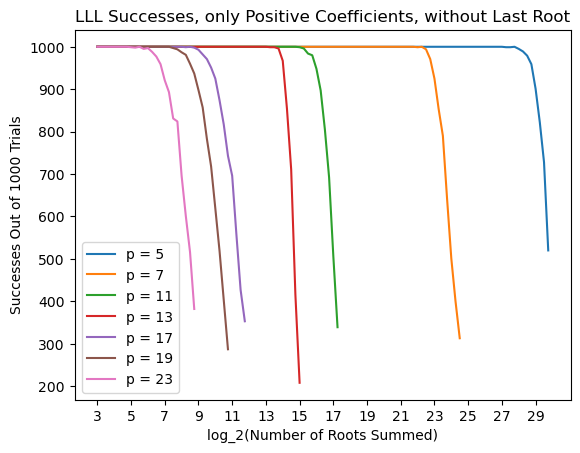

In [ ]:
### Plot algorithm successes (noiseless) vs. l1 norm or positive/negative coefficients or A for p = 5, 7, 11, 13, 17, 19, 23

# vs. l1 norm, varying p, allowing negative coefficients, prec=53, A = 10 ** 16
t5 = np.arange(3.0, 26.5, 0.25)
t7 = np.arange(3.0, 18.25, 0.25)
t11 = np.arange(3.0, 11.75, 0.25)
t13 = np.arange(3.0, 10.25, 0.25)
t17 = np.arange(3.0, 8.5, 0.25)
t19 = np.arange(3.0, 7.75, 0.25)
t23 = np.arange(3.0, 7.0, 0.25)
successes5 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 994, 980, 951, 895, 773, 643, 471, 337]
successes7 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 993, 972, 919, 882, 718, 521, 309]
successes11 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 996, 978, 934, 870, 772, 601, 358]
successes13 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 995, 990, 976, 936, 892, 819, 700, 542, 241]
successes17 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 992, 983, 964, 931, 872, 814, 739, 609, 413, 151]
successes19 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 996, 973, 958, 905, 856, 754, 571, 302]
successes23 = [1000, 1000, 1000, 1000, 1000, 1000, 998, 996, 992, 968, 950, 917, 841, 755, 577, 227]

# vs. l1 norm, varying p, positive coefficients only, prec=53, A = 10 ** 16
t5p = np.arange(3.0, 27.0, 0.25)
t7p = np.arange(3.0, 18.75, 0.25)
t11p = np.arange(3.0, 12.25, 0.25)
t13p = np.arange(3.0, 10.5, 0.25)
t17p = np.arange(3.0, 8.75, 0.25)
t19p = np.arange(3.0, 8.25, 0.25)
t23p = np.arange(3.0, 7.5, 0.25)
successes5p = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 996, 978, 964, 932, 887, 804, 620, 489, 361]
successes7p = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 996, 993, 986, 962, 920, 861, 677, 509, 329]
successes11p = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 997, 995, 977, 959, 931, 894, 782, 570, 296]
successes13p = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 995, 988, 967, 944, 897, 850, 760, 600, 354]
successes17p = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 998, 997, 993, 982, 959, 948, 895, 858, 829, 690, 531, 269]
successes19p = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 995, 985, 990, 973, 960, 912, 864, 732, 479, 255]
successes23p = [1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 998, 993, 982, 971, 936, 913, 840, 666, 404, 184]

# vs. stdev, varying p, prec=53, A = 10 ** 16
t5n = np.arange(3.0, 24.75, 0.25)
t7n = np.arange(3.0, 16, 0.25)
t11n = np.arange(3.0, 8.75, 0.25)
t13n = np.arange(3.0, 7.0, 0.25)
t17n = np.arange(3.0, 4.75, 0.25)
t19n = np.arange(3.0, 4.0, 0.25)
successes5n = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 998, 991, 978, 949, 897, 804, 677, 544, 458, 300]
successes7n = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 991, 977, 931, 826, 756, 558, 419, 309]
successes11n = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 996, 991, 986, 929, 835, 710, 515, 345]
successes13n = [1000, 1000, 1000, 1000, 1000, 1000, 999, 1000, 996, 977, 941, 876, 769, 651, 462, 272]
successes17n = [957, 923, 823, 749, 597, 413, 269]
successes19n = [826, 728, 522, 304]

# vs. l1 norm, varying p, allowing negative coefficients, prec=64, A = 10 ** 20
t56 = np.arange(3.0, 26.5, 0.25)
t76 = np.arange(3.0, 18.25, 0.25)
t116 = np.arange(3.0, 11.75, 0.25)
t136 = np.arange(3.0, 10.25, 0.25)
t176 = np.arange(3.0, 8.5, 0.25)
t196 = np.arange(3.0, 7.75, 0.25)
t236 = np.arange(3.0, 7.0, 0.25)
successes56 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 994, 980, 951, 895, 773, 643, 471, 337]
successes76 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 993, 972, 919, 882, 718, 521, 309]
successes116 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 996, 978, 934, 870, 772, 601, 358]
successes136 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 995, 990, 976, 936, 892, 819, 700, 542, 241]
successes176 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 992, 983, 964, 931, 872, 814, 739, 609, 413, 151]
successes196 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 996, 973, 958, 905, 856, 754, 571, 302]
successes236 = [1000, 1000, 1000, 1000, 1000, 1000, 998, 996, 992, 968, 950, 917, 841, 755, 577, 227]

# vs. l1 norm, varying p, positive coefficients only, prec=64, A = 10 ** 20
t5p6 = np.arange(3.0, 27.0, 0.25)
t7p6 = np.arange(3.0, 18.75, 0.25)
t11p6 = np.arange(3.0, 12.25, 0.25)
t13p6 = np.arange(3.0, 10.5, 0.25)
t17p6 = np.arange(3.0, 8.75, 0.25)
t19p6 = np.arange(3.0, 8.25, 0.25)
t23p6 = np.arange(3.0, 7.5, 0.25)
successes5p6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 996, 978, 964, 932, 887, 804, 620, 489, 361]
successes7p6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 996, 993, 986, 962, 920, 861, 677, 509, 329]
successes11p6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 997, 995, 977, 959, 931, 894, 782, 570, 296]
successes13p6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 995, 988, 967, 944, 897, 850, 760, 600, 354]
successes17p6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 998, 997, 993, 982, 959, 948, 895, 858, 829, 690, 531, 269]
successes19p6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 995, 985, 990, 973, 960, 912, 864, 732, 479, 255]
successes23p6 = [1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 998, 993, 982, 971, 936, 913, 840, 666, 404, 184]

# vs. stdev, varying p, prec=64, A = 10 ** 20
t5n6 = np.arange(3.0, 24.75, 0.25)
t7n6 = np.arange(3.0, 16, 0.25)
t11n6 = np.arange(3.0, 8.75, 0.25)
t13n6 = np.arange(3.0, 7.0, 0.25)
t17n6 = np.arange(3.0, 4.75, 0.25)
t19n6 = np.arange(3.0, 4.0, 0.25)
t23n6 = np.arange(3.0, 4.0, 0.25)
successes5n6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 998, 991, 978, 949, 897, 804, 677, 544, 458, 300]
successes7n6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 991, 977, 931, 826, 756, 558, 419, 309]
successes11n6 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 996, 991, 986, 929, 835, 710, 515, 345]
successes13n6 = [1000, 1000, 1000, 1000, 1000, 1000, 999, 1000, 996, 977, 941, 876, 769, 651, 462, 272]
successes17n6 = [957, 923, 823, 749, 597, 413, 269]
successes19n6 = [826, 728, 522, 304]
successes23n6 = []

# vs. A, allowing negative coefficients, p = 5, prec=256, l1 = 2 ** 26
Alogs = np.arange(2, 51)
successes256m = []

# vs. A, only positive coefficients, p = 5, prec=256, l1 = 2 ** 30
Alogs = np.arange(2, 51)
successes256mp = []

# vs. l1 norm, varying prec / peak A, allowing negative coefficients, p = 5
t53 = []
t64 = []
t128 = []
t256 = []
successes53 = []
successes64 = []
successes128 = []
successes256 = []

# vs. l1 norm, varying prec / peak A, only positive coefficients, p = 5
t53p = []
t64p = []
t128p = []
t256p = []
successes53p = []
successes64p = []
successes128p = []
successes256p = []

# Plotting
plt.plot(t5lp, successes5lp, label='p = 5')
plt.plot(t7lp, successes7lp, label='p = 7')
plt.plot(t11lp, successes11lp, label='p = 11')
plt.plot(t13lp, successes13lp, label='p = 13')
plt.plot(t17lp, successes17lp, label='p = 17')
plt.plot(t19lp, successes19lp, label='p = 19')
plt.plot(t23lp, successes23lp, label='p = 23')
plt.title("LLL Successes, only Positive Coefficients, without Last Root")
plt.xlabel("log_2(Number of Roots Summed)")
plt.xticks(np.arange(3, 31, 2))
plt.ylabel("Successes Out of 1000 Trials")
plt.legend()
plt.show()

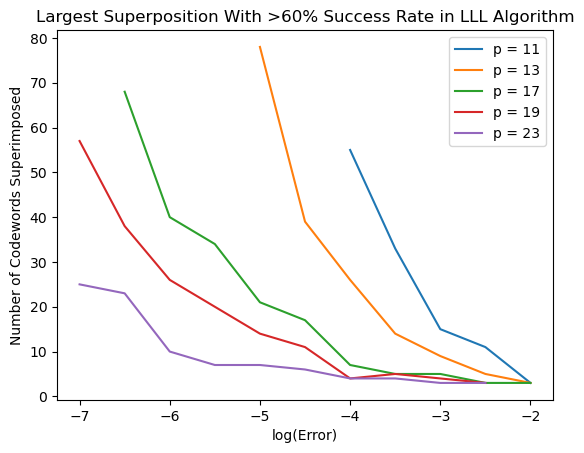

In [ ]:
### Plot max superposition for p = 11, 13, 17, 19, 23 vs error (outdated)

log_error11 = np.arange(-4.0, -1.5, 0.5)
log_error13 = np.arange(-5.0, -1.5, 0.5)
log_error17 = np.arange(-6.5, -1.5, 0.5)
log_error19 = np.arange(-7.0, -2.0, 0.5)
successes11e = [55, 33, 15, 11, 3]
successes13e = [78, 39, 26, 14, 9, 5, 3]
successes17e = [68, 40, 34, 21, 17, 7, 5, 5, 3, 3]
successes19e = [57, 38, 26, 20, 14, 11, 4, 5, 4, 3]
successes23e = [25, 23, 10, 7, 7, 6, 4, 4, 3, 3]
plt.plot(log_error11, successes11e, label='p = 11')
plt.plot(log_error13, successes13e, label='p = 13')
plt.plot(log_error17, successes17e, label='p = 17')
plt.plot(log_error19, successes19e, label='p = 19')
plt.plot(log_error19, successes23e, label='p = 23')
plt.title("Largest Superposition With >60% Success Rate in LLL Algorithm")
plt.xlabel("log(Error)")
plt.xticks([-7, -6, -5, -4, -3, -2])
plt.ylabel("Number of Codewords Superimposed")
plt.legend()
plt.show()


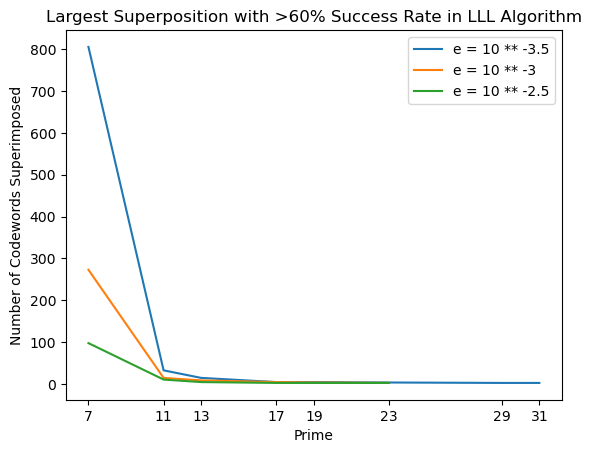

In [ ]:
### Plot max superposition for e = 10 ** -3.5 (outdated)
primes_25 = [7, 11, 13, 17, 19, 23]
primes_35 = [7, 11, 13, 17, 19, 23, 29, 31]
superpositions25 = [98, 11, 5, 3, 3, 3]
superpositions30 = [273, 15, 9, 5, 4, 3]
superpositions35 = [805, 33, 15, 5, 5, 4, 3, 3]
plt.plot(primes_35, superpositions35, label="e = 10 ** -3.5")
plt.plot(primes_25, superpositions30, label="e = 10 ** -3")
plt.plot(primes_25, superpositions25, label="e = 10 ** -2.5")
plt.title("Largest Superposition with >60% Success Rate in LLL Algorithm")
plt.xlabel("Prime")
plt.xticks(primes_35)
plt.ylabel("Number of Codewords Superimposed")
plt.legend()
plt.show()

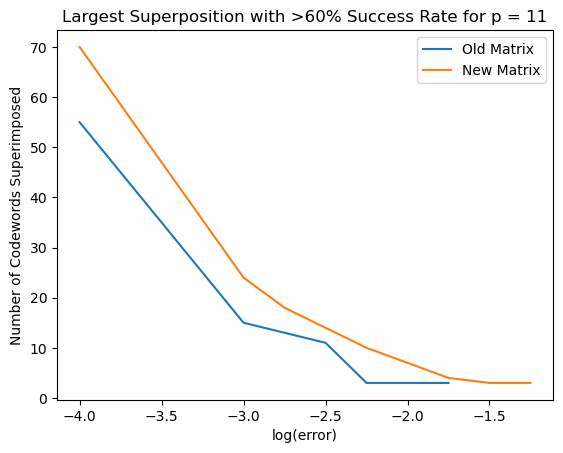

In [57]:
### Plot noise max superpositions in old and new formulations
old_elogs7 = [-3, -2.5, -2.25, -2, -1.75, -1.5, -1.25]
old_elogs11 = [-4, -3, -2.5, -2.25, -2, -1.75]
new_elogs7 = np.arange(-3.0, -0.75, 0.25)
new_elogs11 = [-4, -3, -2.75, -2.5, -2.25, -2, -1.75, -1.5, -1.25]
maxes_old7 = [273, 98, 35, 28, 14, 8, 7]
maxes_old11 = [55, 15, 11, 3, 3, 3]
maxes_new7 = [265, 154, 96, 58, 37, 25, 12, 8, 4]
maxes_new11 = [70, 24, 18, 14, 10, 7, 4, 3, 3]
plt.plot(old_elogs11, maxes_old11, label="Old Matrix")
plt.plot(new_elogs11, maxes_new11, label="New Matrix")
plt.title("Largest Superposition with >60% Success Rate for p = 11")
plt.xlabel("log(error)")
plt.ylabel("Number of Codewords Superimposed")
plt.legend()
plt.show()